# Visualizing and Animating positions

In [1]:
## Load in some dependencies
library(dplyr); library(data.table); library(ggplot2); library(ggforce)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
nhwl_df <- read.csv("../input/nhwldata/Rotman MMA Summer Datathon NWHL.csv")
head(nhwl_df)

game_date  Home.Team           Away.Team    Period Clock Home.Team.Skaters
1 2021-01-23 Minnesota Whitecaps Boston Pride 1      20:00 5                
2 2021-01-23 Minnesota Whitecaps Boston Pride 1      19:58 5                
3 2021-01-23 Minnesota Whitecaps Boston Pride 1      19:57 5                
4 2021-01-23 Minnesota Whitecaps Boston Pride 1      19:55 5                
5 2021-01-23 Minnesota Whitecaps Boston Pride 1      19:53 5                
6 2021-01-23 Minnesota Whitecaps Boston Pride 1      19:52 5                
  Away.Team.Skaters Home.Team.Goals Away.Team.Goals Team         ⋯
1 5                 0               0               Boston Pride ⋯
2 5                 0               0               Boston Pride ⋯
3 5                 0               0               Boston Pride ⋯
4 5                 0               0               Boston Pride ⋯
5 5                 0               0               Boston Pride ⋯
6 5                 0               0               Boston Pride ⋯
  Event         X.Coordinate Y.Coordinate Detail.1 Detail.2 Detail.3 Detail.4
1 Faceoff Win   100          43           Backhand                           
2 Puck Recovery 107          40                                              
3 Zone Entry    125          28           Carried                            
4 Shot          131          28           Snapshot On Net   t        f       
5 Faceoff Win   169          21           Backhand                           
6 Puck Recovery 159          26                                              
  Player.2           X.Coordinate.2 Y.Coordinate.2
1 Stephanie Anderson NA             NA            
2                    NA             NA            
3 Maddie Rowe        NA             NA            
4                    NA             NA            
5 Stephanie Anderson NA             NA            
6                    NA             NA

In [3]:
nhwl_plays_df <- nhwl_df %>%
  filter(Event %in% c("Play", "Incomplete Play"), Detail.1 == "Direct", X.Coordinate >= 125, X.Coordinate.2 >= 125) %>%
  mutate(start_x = Y.Coordinate,
         start_y = X.Coordinate,
         end_x = Y.Coordinate.2,
         end_y = X.Coordinate.2,
         
         delta_x = end_x - start_x,
         delta_y = end_y - start_y,
         
         is_complete = ifelse(Event == "Play", 1, 0))

head(nhwl_plays_df,10)

game_date  Home.Team           Away.Team    Period Clock Home.Team.Skaters
1  2021-01-23 Minnesota Whitecaps Boston Pride 1      19:43 5                
2  2021-01-23 Minnesota Whitecaps Boston Pride 1      19:08 5                
3  2021-01-23 Minnesota Whitecaps Boston Pride 1      18:51 5                
4  2021-01-23 Minnesota Whitecaps Boston Pride 1      18:36 5                
5  2021-01-23 Minnesota Whitecaps Boston Pride 1      18:29 5                
6  2021-01-23 Minnesota Whitecaps Boston Pride 1      16:50 5                
7  2021-01-23 Minnesota Whitecaps Boston Pride 1      16:40 5                
8  2021-01-23 Minnesota Whitecaps Boston Pride 1      16:38 5                
9  2021-01-23 Minnesota Whitecaps Boston Pride 1      16:32 5                
10 2021-01-23 Minnesota Whitecaps Boston Pride 1      16:30 5                
   Away.Team.Skaters Home.Team.Goals Away.Team.Goals Team                ⋯
1  5                 0               0               Minnesota Whitecaps ⋯
2  5                 0               0               Minnesota Whitecaps ⋯
3  5                 0               0               Boston Pride        ⋯
4  5                 0               0               Boston Pride        ⋯
5  5                 0               0               Boston Pride        ⋯
6  5                 0               0               Minnesota Whitecaps ⋯
7  5                 0               0               Boston Pride        ⋯
8  5                 0               0               Boston Pride        ⋯
9  5                 0               0               Boston Pride        ⋯
10 5                 0               0               Boston Pride        ⋯
   Player.2         X.Coordinate.2 Y.Coordinate.2 start_x start_y end_x end_y
1  Haley Mack       196            33             20      193     33    196  
2  Nina Rodgers     161            14             10      168     14    161  
3  McKenna Brand    175            47             65      195     47    175  
4  McKenna Brand    168            74             52      135     74    168  
5  Lauren Kelly     165            22             82      174     22    165  
6  Haylea Schmid    180            48             53      199     48    180  
7  Samantha Davis   180            42             64      175     42    180  
8  Taylor Turnquist 143            81             63      174     81    143  
9  Samantha Davis   198            46             61      198     46    198  
10 Lauren Kelly     163            10             19      193     10    163  
   delta_x delta_y is_complete
1   13       3     1          
2    4      -7     1          
3  -18     -20     0          
4   22      33     1          
5  -60      -9     0          
6   -5     -19     1          
7  -22       5     0          
8   18     -31     1          
9  -15       0     1          
10  -9     -30     1

In [4]:
# nhwl_plays_df <- nhwl_plays_df[nhwl_plays_df$Player == 'Taylor Woods', ]
# nhwl_plays_df <- nhwl_plays_df[nhwl_plays_df$Period == 2, ]
# nhwl_plays_df <- nhwl_plays_df[nhwl_plays_df$game_date == '2021-01-31', ]
# nhwl_plays_df

## Clustering

In [5]:
cluster_fit <- kmeans(nhwl_plays_df %>% select(start_x: delta_y), centers = 50)
nhwl_plays_df$cluster <- cluster_fit$cluster

In [6]:
cluster_summary <- nhwl_plays_df %>%
  group_by(cluster) %>%
  summarise(total_passes = n(),
            comp_rate = mean(is_complete))

risky_passes <- (cluster_summary %>%
                   arrange(comp_rate) %>%
                   .$cluster)[1:3]

safe_passes <- (cluster_summary %>%
                   arrange(desc(comp_rate)) %>%
                   .$cluster)[1:3]

## Plotting static clusters

In [7]:
# Plot clusters
risky_dat <- bind_rows(nhwl_plays_df %>%
                         filter(cluster == risky_passes[1]) %>%
                         sample_n(20, replace = FALSE),
                       nhwl_plays_df %>%
                         filter(cluster == risky_passes[2]) %>%
                         sample_n(20, replace = FALSE),
                       nhwl_plays_df %>%
                         filter(cluster == risky_passes[3]) %>%
                         sample_n(20, replace = FALSE))


risky_passes_plot <- ggplot(data = risky_dat, aes(end_x, end_y, col = factor(cluster))) + 
  geom_segment(aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
               arrow = arrow(length = unit(0.3, "cm"))) +
  geom_circle(data = data.frame(x0 = 42.5, y0 = 100, r = 15), aes(x0 = x0, y0 = y0, r = r), 
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 20.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 64.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_point(inherit.aes = FALSE, aes(x = 42.5, y = 100),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 120),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 120),
             col = "gray50", size = 1) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 0, y = 189, xend = 85, yend = 189)) +
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 45.5, yend = 192.5)) + 
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 39.5, yend = 189)) +  
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 45.5, y = 192.5, xend = 45.5, yend = 189)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 33.5, y = 189, xend = 28.5, yend = 200)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 51.5, y = 189, xend = 56.5, yend = 200)) +
  geom_hline(col = "gray50", yintercept = 125, lwd = 0.5) +
  scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0,0)) +
  ylab("OFFENSIVE ZONE") +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y = element_text(size=12),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        panel.border = element_rect(colour = "gray50", fill=NA, size=0.2)) +
  coord_fixed(xlim = c(0,85), ylim = c(100,200)) +
  annotate("label", x = 42.5, y = 112.5, label = "Risky Passes", size = 5.5, fill = "mistyrose")


safe_dat <- bind_rows(nhwl_plays_df %>%
                        filter(cluster == safe_passes[1]) %>%
                        sample_n(20, replace = FALSE),
                      nhwl_plays_df %>%
                        filter(cluster == safe_passes[2]) %>%
                        sample_n(20, replace = FALSE),
                      nhwl_plays_df %>%
                        filter(cluster == safe_passes[3]) %>%
                        sample_n(20, replace = FALSE))


safe_passes_plot <- ggplot(data = safe_dat, aes(end_x, end_y, col = factor(cluster))) + 
  geom_segment(aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
               arrow = arrow(length = unit(0.3, "cm"))) +
  geom_circle(data = data.frame(x0 = 42.5, y0 = 100, r = 15), aes(x0 = x0, y0 = y0, r = r), 
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 20.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 64.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_point(inherit.aes = FALSE, aes(x = 42.5, y = 100),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 120),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 120),
             col = "gray50", size = 1) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 0, y = 189, xend = 85, yend = 189)) +
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 45.5, yend = 192.5)) + 
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 39.5, yend = 189)) +  
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 45.5, y = 192.5, xend = 45.5, yend = 189)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 33.5, y = 189, xend = 28.5, yend = 200)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 51.5, y = 189, xend = 56.5, yend = 200)) +
  geom_hline(col = "gray50", yintercept = 125, lwd = 0.5) +
  scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0,0)) +
  ylab("OFFENSIVE ZONE") +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y = element_text(size=12),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        panel.border = element_rect(colour = "gray50", fill=NA, size=0.2)) +
  coord_fixed(xlim = c(0,85), ylim = c(100,200)) +
  annotate("label", x = 42.5, y = 112.5, label = "Safe Passes", size = 5.5, fill = "azure")

Risky passes: 

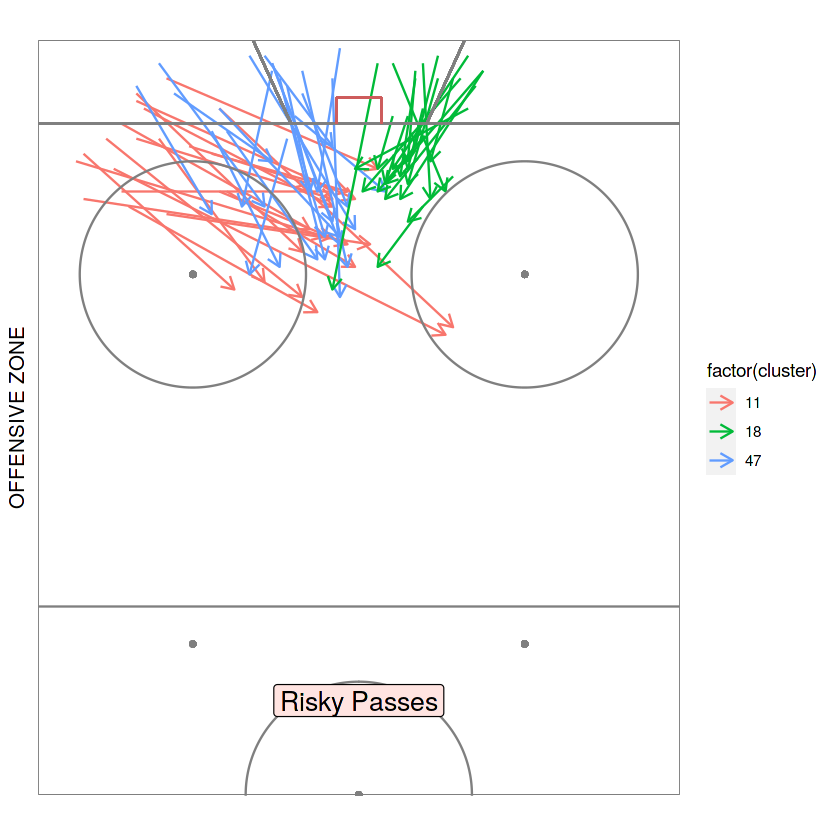

In [8]:
cat("Risky passes: ")
print(risky_passes_plot)

Safe passes: 

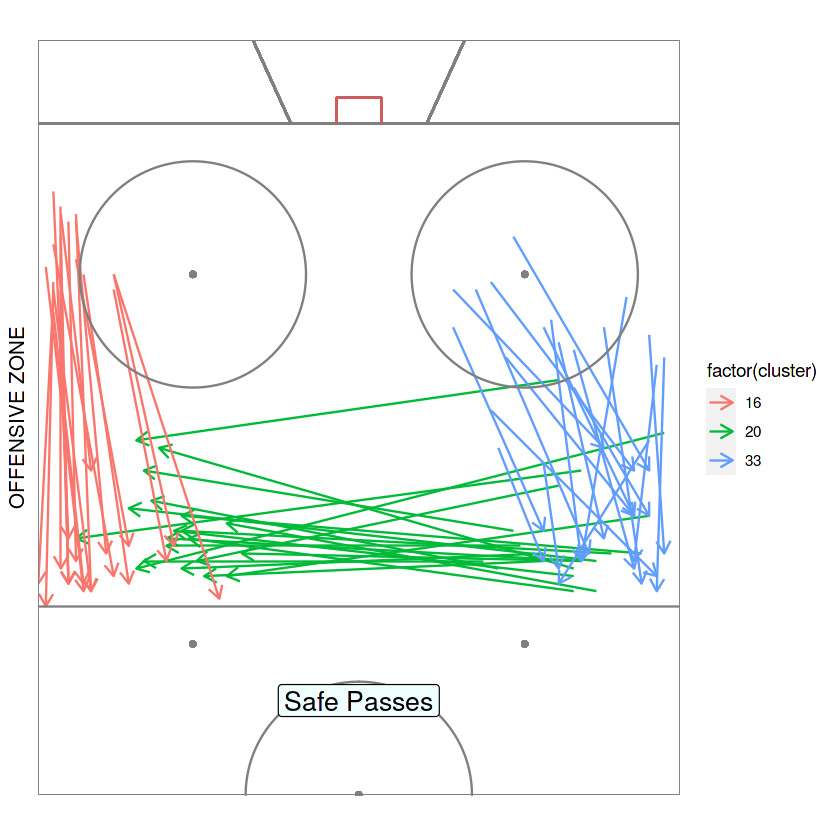

In [9]:
cat("Safe passes: ")
print(safe_passes_plot)

As we can see risky passes are close to the goal while the safe passes are away from the goal

In [10]:
library(gganimate)

anim <- risky_passes_plot + 
                      transition_states(Clock)

anim

## Visualizing the Passes of Taylor woods

In [11]:
passes_players_df <- nhwl_plays_df[nhwl_plays_df$Player == 'Taylor Woods',]
head(passes_players_df)

game_date  Home.Team             Away.Team           Period Clock
394 2021-01-23 Metropolitan Riveters Toronto Six         1      10:44
422 2021-01-23 Metropolitan Riveters Toronto Six         1      4:15 
424 2021-01-23 Metropolitan Riveters Toronto Six         1      4:12 
489 2021-01-23 Metropolitan Riveters Toronto Six         2      2:29 
933 2021-01-24 Toronto Six           Minnesota Whitecaps 1      12:12
951 2021-01-24 Toronto Six           Minnesota Whitecaps 1      8:34 
    Home.Team.Skaters Away.Team.Skaters Home.Team.Goals Away.Team.Goals
394 4                 5                 1               0              
422 4                 5                 1               0              
424 4                 5                 1               0              
489 5                 5                 2               0              
933 5                 4                 0               0              
951 5                 4                 2               0              
    Team        ⋯ X.Coordinate.2 Y.Coordinate.2 start_x start_y end_x end_y
394 Toronto Six ⋯ 162            10             27      131     10    162  
422 Toronto Six ⋯ 153            16             58      134     16    153  
424 Toronto Six ⋯ 149            63             40      129     63    149  
489 Toronto Six ⋯ 129            18             60      159     18    129  
933 Toronto Six ⋯ 135            14             47      135     14    135  
951 Toronto Six ⋯ 126            65             33      130     65    126  
    delta_x delta_y is_complete cluster
394 -17      31     1           43     
422 -42      19     1           21     
424  23      20     1           38     
489 -42     -30     1           46     
933 -33       0     1           27     
951  32      -4     1           12

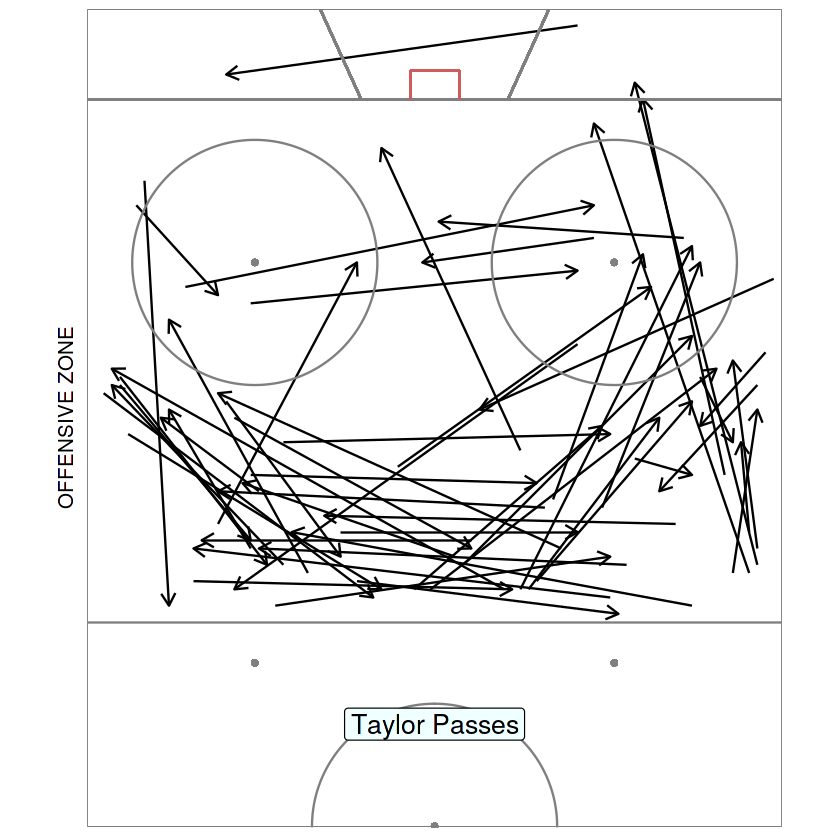

In [12]:
taylor_passes_plot <- ggplot(data = passes_players_df, aes(end_x, end_y)) + 
  geom_segment(aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
               arrow = arrow(length = unit(0.3, "cm"))) +
  geom_circle(data = data.frame(x0 = 42.5, y0 = 100, r = 15), aes(x0 = x0, y0 = y0, r = r), 
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 20.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 64.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_point(inherit.aes = FALSE, aes(x = 42.5, y = 100),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 120),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 120),
             col = "gray50", size = 1) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 0, y = 189, xend = 85, yend = 189)) +
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 45.5, yend = 192.5)) + 
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 39.5, yend = 189)) +  
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 45.5, y = 192.5, xend = 45.5, yend = 189)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 33.5, y = 189, xend = 28.5, yend = 200)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 51.5, y = 189, xend = 56.5, yend = 200)) +
  geom_hline(col = "gray50", yintercept = 125, lwd = 0.5) +
  scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0,0)) +
  ylab("OFFENSIVE ZONE") +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y = element_text(size=12),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        panel.border = element_rect(colour = "gray50", fill=NA, size=0.2)) +
  coord_fixed(xlim = c(0,85), ylim = c(100,200)) +
  annotate("label", x = 42.5, y = 112.5, label = "Taylor Passes", size = 5.5, fill = "azure")

taylor_passes_plot

In [ ]:
library(gganimate)

anim <- taylor_passes_plot + transition_states(end_x)

anim

In [58]:
cluster_taylor_passes <- kmeans(passes_players_df %>% select(start_x: delta_y), centers = 5)
passes_players_df$cluster <- cluster_taylor_passes$cluster
cluster_taylor_passes

K-means clustering with 5 clusters of sizes 16, 16, 10, 6, 7

Cluster means:
   start_x  start_y    end_x    end_y   delta_x    delta_y
1 14.93750 150.6250 43.68750 140.0625  28.75000 -10.562500
2 62.37500 134.5625 72.25000 162.9375   9.87500  28.375000
3 59.30000 135.3000 17.40000 139.8000 -41.90000   4.500000
4 26.83333 136.8333 16.83333 161.5000 -10.00000  24.666667
5 74.14286 168.0000 53.28571 160.4286 -20.85714  -7.571429

Clustering vector:
 394  422  424  489  933  951  955 1027 1057 1058 1063 1071 1104 1139 1161 1192 
   4    3    2    3    3    1    4    1    5    5    2    2    3    1    5    5 
1289 1291 1294 1345 1808 1858 1859 1863 1868 1887 1921 1938 1940 1959 2231 2238 
   1    1    1    1    4    1    5    5    3    1    1    3    2    5    4    3 
2241 2255 2256 2305 2308 2313 2318 2319 2344 2422 2654 2656 2662 2681 2724 2726 
   1    1    2    1    4    2    1    2    2    1    3    2    2    2    3    2 
2729 2734 2738 2740 2742 2751 2771 
   2    4    3    2    2   

In [59]:
cluster_summary <- passes_players_df %>%
                      group_by(cluster) %>%
                      summarise(total_passes = n(),
                      comp_rate = mean(is_complete))


risky_passes <- (cluster_summary %>%
                   arrange(comp_rate) %>%
                   .$cluster)[1:5]

safe_passes <- (cluster_summary %>%
                   arrange(desc(comp_rate)) %>%
                   .$cluster)[1:3]

risky_passes

[1] 5 4 2 1 3

In [42]:
image <- jpeg::readJPEG("../input/ice-hockey-half-rink/ice_hockey_half_rink.jpg")

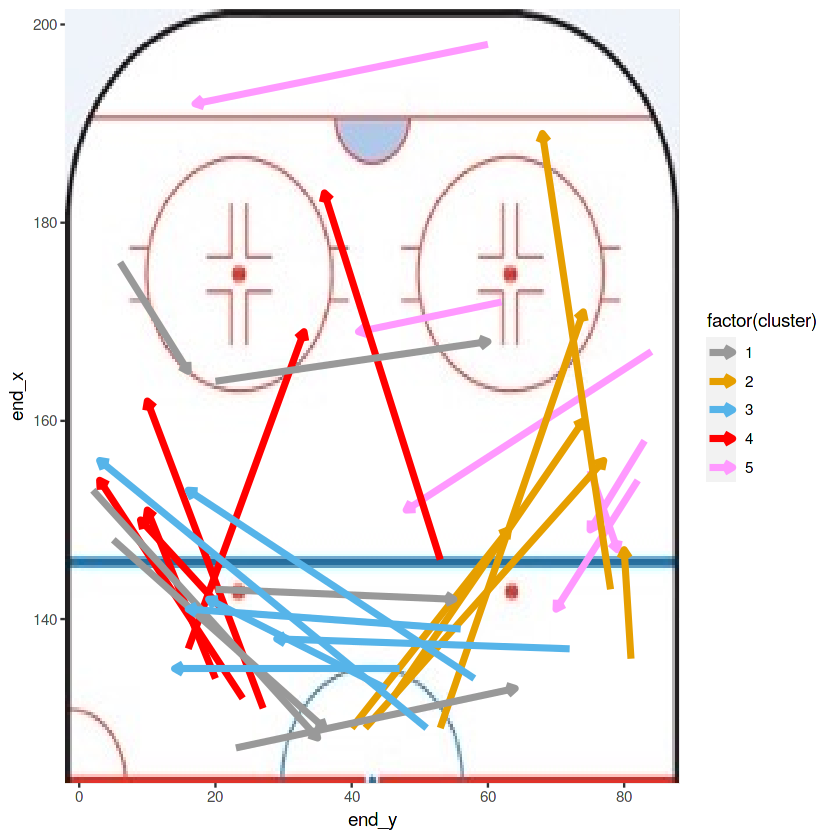

In [82]:
library(grid)
library(ggpubr)
library(gggenes)

risky_dat <- bind_rows(passes_players_df %>%
                         filter(cluster == risky_passes[1]) %>%
                         sample_n(6, replace = FALSE),
                       passes_players_df %>%
                         filter(cluster == risky_passes[2]) %>%
                         sample_n(6, replace = FALSE),
                       passes_players_df %>%
                         filter(cluster == risky_passes[3]) %>%
                         sample_n(6, replace = FALSE),
                      passes_players_df %>%
                         filter(cluster == risky_passes[4]) %>%
                         sample_n(6, replace = FALSE),
                      passes_players_df %>%
                         filter(cluster == risky_passes[5]) %>%
                         sample_n(6, replace = FALSE))


risky_passes_plot <- ggplot(data = risky_dat, aes(end_y, end_x, col = factor(cluster))) + 
  background_image(image) +
  geom_segment(aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
               arrow = arrow(length = unit(0.2, "cm")), size=1.5) +
  scale_fill_continuous(guide = FALSE) +
  scale_color_manual(values=c('#999999','#E69F00', '#56B4E9', '#ff0000', '#ff99ff'))

risky_passes_plot

In [83]:
save.image(file = "taylor_plays.Rdata", oldstyle = FALSE)

ERROR: Error in save.image(file = "taylor_plays.Rdata", oldstyle = FALSE): unused argument (oldstyle = FALSE)


In [84]:
library(gganimate)

anim <- risky_passes_plot + transition_states(end_x)

anim

<img src="data:image/gif;base64,R0lGODlh4AHgAfcAAAoJCw0OERQTFBwbHRcWGRQOESEdHicYFjkUEBwdIiUdIhUkLiMhIioq
KyclKD49PTU0NTAtMCAiHkI7O1o1KFshGDw8Qi4/RUE8QC5QZEdHSFBOT1dWWFBOUV1dY2Ji
ZGpqbHNycnx8fHR2eHJvcWNcYLs6NLU7NbE5M4c0L/8AAP8MDP8WFu0SFt4zKtk3Kcs5Nf8o
KP41NeIzKtwrHLNBPMZCO+xMPZdLTLZJRq1QT41qapRsa5VtdJl3d49xcKR8faV6d7Rvbqtg
XdtSSM5QTeJPRuJOSOlPReFRSP9PT81tav1xccpiW643SOafAOenFpyBfqSCfeq9ViVtnStt
mSZwny10njVskCZypCZvoRtwpXJ9hFJ1jJl6hYR8gqZ9gq5+lMJ8hnmMl3GJkl2cv12Wt26X
smiSqF2bxEKXyW+rzm2lwHKqznenxWys1Fa06Vu26VOv5Ge763C/7FmiznjD7W7A7TeIuYSE
hIiHh4yLjIaHiZqFhpOTlJycnJiXmomTmKOEg6qEhauMi6aIibKNjLaGhqqRjKqMlreNk6uU
l7STlLmYmbWSjbmgnI2apKuWo7iZo7KPp46jqpistaOjpKuqq6mlqLmmqLGvsLmqt6mzt7Ox
sry8vba0uK+wsMWZmtaTkvSSkcuinMWdpceoqNSpqcuxrdOyrtuzqsertMu2ttSysdu8vNe4
uNSrsuS5ufu5uO6rqOmintnBvv/CvfjBuenJuu7VoLC8yKK30tm9w8u6z/+Z/+2357jF2bDE
0JrT8o3M763K5avI6rPE5bPF7LjI6K/X8rrh9sfHx9vCwtjHyMnG2tjY2c3N2evMy+bGxv/D
w/fLyuvSzO3d2+jW1PTd3Pzc3PfX1fLO0Pzi3vXh3O7i0c/T4/re4e3Z7Njs99///93y+83l
8evr7OXk5f7k4/7q5f/m6f/s7PTm5v/y7f747uzu8+js9f/t8vPr9e3x9u/0+uP//+39/+T0
/PLz8//08/b79v769fL0+v72+vT+/v///yH5BAQKAAAAIf8LTkVUU0NBUEUyLjADAQAAACwA
AAAA4AHgAQAI/gD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihxJsqTJ
kyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6dPk/s09vtJtOjAoQ2RGl3K1CA/fvjwPZWqD6pV
qVihSoVKjx4+r13paZ1KFt+8rGOjPq36tG3brfje6fO31p++ffjOnXsGzZMnTIDyCB5MeLCe
woQP61nMuLFjxnsgP578OPLiPZYpU86cWfPhzpw9aw4t+fJiwYcR6+Hj59Ky18/O8dPXz5+/
2vrwVVW7O+pWqPPczvPKL3jUs259w82dtuzVq3DVZtXX1GjY69iz88se9l5Ye9y7/ne1t/06
PH7y2or1N29e7ae135njd3ufv4Hznj1bhgkziAkMGCDgAAMEOIAEBgwg4IAEKmgAAxIwIOGE
FFZo4YUYZqjhhhx26OGHGDowIYIIGqDAAAkMICIEJOyBySW9PEPbP0j1049vVj0lT1fviJWd
d+ddN5yP2GEV3pFEcleeV9UVNWRYS0Z55JJIikVlV1f6g2V5b0ElzztPCWQjP+dAY4klXIDA
AQcPQNBABA0YIIAABMxppwAF3ImnnnMSUGefev7J56CA3ikooXweSieihCqqKKOF2vkoopPe
maedA9Dp55ttYsDBBx98gcky0JyDj0C3NfeUlth5l92Q/lQuOdxTUF4nZXhXhtUkUU9W6auv
tGpn63bq2djeU++Ayc9QWvJjzjKXWDKCmhxcAEEEcDKwaJ0F5HnppXaC66emkJYbqbnopnuu
uuwyWqmeefopL7ZtavApCKK+xg4/YtI1VY+rcnlPrtgR/NXB4BHMZZFV7vqTkkliWTDBv9Lj
aq1PwRMcP/AoqyM+Yzq7zBcddBDBAOPqKWEEE2igwQZrxizzzByUsGYHG+T8cs489+zzzxvg
DPTQRBdtdNBHHy100kz7XDLMHdy8gcsWRJBAAAQUQEAAAeSZQAIRcPDFF56cU1s/8PGTLLJW
bnfxdV9VLDfFwZ7qME33HSR3/q0+xiqexBK/vaN6XQUnz7HFydPxUNuZowvJJqN8aAACrNzy
yzbTnPmam3OA9NRNOx060EuPznPppn+ees6oD11yyTJPrUHVCcypNdd+Ehg2F2Sb/Z6/Havd
lb97L8z33g3fjRI+IoyQx317kLHIP/7wEcUfBj1pfMTYBfcj8gXTgzZ88/SI9pfQ/OGBBw10
W2cCDlhggQcj/PFHLcvoZU7eFNV4FEH++5+YBEgjAirlgAM0YAIXiEAGKtCBBRSgUiJIwQZG
0II2+kdeoNGMXgBCBCLggAUc4IAEXCoADuDAHwDxjODMRVnaoRjyvsIl8EyJO3ZTnkk+cYl/
WIIV/rWwxD/4cI5lCHEP5yiI9opHD+9dx4Y4RFLG0lMc96BHF35YUwIA0DUFWOADfODDJ0xl
t31Q54E6TONBqvKPoBRQKfqITSf28IESaMABAMgjAzqAmV4QyzY8Ihz4fiXD7ZDnOmosyTPM
8Y9OBAMQy/jHJTzxh0hiwhMCeYYnPgGPKhlPSsEaJD12JBaNWXEe8vjHdnqRRQ5sUQABSIAF
QLAaTzwjKgI540H4JxFeJhIn/dhHUM5oGzf+I47P6IQeSvCBEeYRAA7oQCD2sIwtCc9jEAMc
365USO5lJ4e/FMkyRIAPFv7jE5wIxDP+4YlOCMQSIADBOURZOBlK8Tqk/hQfyGj0jFY2gIsA
aIAH/OCHZZgDnGv0h30OohRjhpMp98kbL5EyIzfm5hyPBFUEuBiABnAAEH54Bj2oVxyAEcke
cbPnPb0pxYeK5BJ7OFUlJRlES2KSIE48nq0mJpa4XedtuMLO4OhjI2gAomQNCAAXBUpQg/JL
IbTxRz7aOBBfEsShLu3JBLd6n7kQRB/5KCIgQIVHrjVAmiHlV23i1qug3rBi3OzKV7L6kWVg
TyD8+QcSoaXXJBIkLKzSqZLcos3wODFYbgnTMuJpAQV0LQEgiIQlTOW/2yiFf76sDV3DeRvq
vbGqxswgPszxjEusbwBYI0AESPCa+6gnlIVd/qlgWcq3zXYEECQYQQgiiRns6aO3BpnbxGYF
2/DtNLHL4scyPKAAOhUAAn7YwzX4N0EKWpdxWLVtVq1qQYFE5Rx+eIAF6oQiDywjZMUllihV
yh3tvqRX7OVSeoLT1vC1x5rI7cdymwtL6PphugfcKgAF4kYzuvfACOnsQC4a3vESwAAJMK9t
qnjcG/rNkxWWK4JZkk3AcbMtxIVSJ8GEuE4mR23QiKef9tgBUMhDswvcsIwxUt3ZWGIDDXBA
ABQAKmjQw1+zgUcn+Xae4sbWre2dMUowjCvCXSlZ3tvYxoozvnekGAQoU0DJNAGyACr5yxjp
qj4woYEcx7LHP3ZL/rJ2KmRB3tOn4wkPQsEcElgVDz1U1CaxaFWcJr5jys5YxgiuFgAIcOAT
YbJRdxFSXTo7Wkz6oA4/dOGJD0SAawlgbXH8AaZmCZl7t4JrrXz66JEIi7bbpFh7kJMsRZNp
BBCAQCzjGYypZvCYxsxuqXdNEAVb95jBCAEJrhYBLohgnTYCGF3a9mNU2xPOiOT1R4QbV6/Y
sDyzAlNcGHkbf4SDCxaQtQLiyQp+KbgfupS2tButEHzUIgSDDkAEfkCGddLlHUXe8/DeulNg
qdsj9NxOPidG4uSG6UwW2CIAOLCMqAxlRtQbCrv/TeeJXxYp/ojKcgHwNQhggka3WTXh/urL
xH5TnCM5VW+1h0WkJUmlib9ZFcIVzvC4EJiAA9H1yUttVRrpZuMdx4Rtkj1ljtGjR1WCtkrn
vHOK0FOK7VkbreRxDg98rdCYqE